In [1]:
# Cell 1: Imports (install step is usually not needed in Colab for sklearn)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
# Cell 2: Setup and Data Loading

import pandas as pd
from google.colab import files
import os

filename = "CEAS_08.csv"

# Check if the file exists, if not, prompt for upload
if not os.path.exists(filename):
  print(f"File '{filename}' not found. Please upload it now.")
  uploaded = files.upload()
  if filename not in uploaded:
    print(f"Error: '{filename}' was not uploaded. Please ensure you upload the correct file.")

# If the file exists (either pre-existing or just uploaded), try to read it
df = pd.read_csv(
    filename,
    engine="python",
    on_bad_lines="skip")

print(df.shape)
df.head()

File 'CEAS_08.csv' not found. Please upload it now.


Saving CEAS_08.csv to CEAS_08.csv
(39153, 7)


,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [3]:
# Cell 3: Basic info and Class Balance

# Check data types and total entries
df.info()

print("\n--- Class Balance ---")
print(df['label'].value_counts())

print("\n--- Missing Values ---")
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39153 entries, 0 to 39152
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39153 non-null  object
 1   receiver  38691 non-null  object
 2   date      39153 non-null  object
 3   subject   39125 non-null  object
 4   body      39153 non-null  object
 5   label     39153 non-null  int64 
 6   urls      39153 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB

--- Class Balance ---
label
1    21842
0    17311
Name: count, dtype: int64

--- Missing Values ---
sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64


In [4]:
# Cell 4: Preprocessing and Feature Engineering


# Handle missing values (using 'no subject' as placeholder)
df['subject'] = df['subject'].fillna('no subject')
df['body'] = df['body'].fillna('')

# Normalize text to lowercase
df['subject'] = df['subject'].str.lower()
df['body'] = df['body'].str.lower()

# Create Feature: Length of the email and subject
df['subject_length'] = df['subject'].apply(len)
df['email_length'] = df['body'].apply(len)

# Create Feature: Extract the sender's domain (e.g., gmail.com)
df['sender_domain'] = df['sender'].apply(lambda x: x.split('@')[-1].replace('>', '').strip() if isinstance(x, str) else 'unknown')

# Combine subject and body into one column for the model
df['text'] = df['subject'] + " " + df['body']

# Ensure label is int (0 = ham, 1 = spam/phishing)
df['label'] = df['label'].astype(int)

# Quick check
print("Preprocessing complete.")
df[['subject', 'text', 'sender_domain', 'label']].head()

Preprocessing complete.


,subject,text,sender_domain,label
0,never agree to be a loser,"never agree to be a loser buck up, your troubl...",iworld.de,1
1,befriend jenna jameson,befriend jenna jameson \nupgrade your sex and ...,icable.ph,1
2,cnn.com daily top 10,cnn.com daily top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,universalnet.psi.br,1
3,re: svn commit: r619753 - in /spamassassin/tru...,re: svn commit: r619753 - in /spamassassin/tru...,pobox.com,0
4,specialpricespharmmoreinfo,specialpricespharmmoreinfo \nwelcomefastshippi...,loanofficertool.com,1


In [5]:
# Cell 5: Train-test split


X = df['body']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 31322
Test size: 7831


In [6]:
# Cell 6: Build pipeline (TF-IDF + Logistic Regression)

model = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_features=30000  # you can tune this
    )),
    ('clf', LogisticRegression(
        max_iter=200,
        n_jobs=-1
    ))
])

# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=30000, stop_words='english')),
                ('clf', LogisticRegression(max_iter=200, n_jobs=-1))])

In [7]:
# Cell 7: Evaluate the model

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generate predictions on the test set
y_pred = model.predict(X_test)

# Print the accuracy
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred):.4f}")

# Print detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing'], digits=4))

# Print raw confusion matrix numbers
print("\nConfusion Matrix (Raw Numbers):")
print(confusion_matrix(y_test, y_pred))


Accuracy on Test Set: 0.9948

Classification Report:
              precision    recall  f1-score   support

  Legitimate     0.9939    0.9942    0.9941      3462
    Phishing     0.9954    0.9952    0.9953      4369

    accuracy                         0.9948      7831
   macro avg     0.9947    0.9947    0.9947      7831
weighted avg     0.9948    0.9948    0.9948      7831


Confusion Matrix (Raw Numbers):
[[3442   20]
 [  21 4348]]


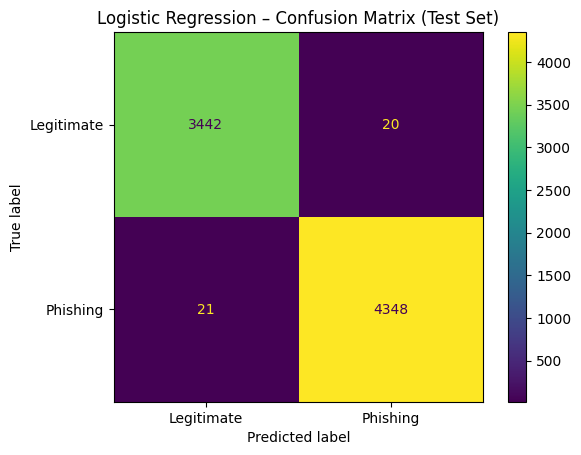

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Visual confusion matrix ("matrix box") for Logistic Regression
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=['Legitimate', 'Phishing']
)
plt.title("Logistic Regression – Confusion Matrix (Test Set)")
plt.show()


In [9]:
# Cell 8: Check a few random emails and predictions

sample_df = df.sample(5, random_state=0).copy()
sample_df['predicted_label'] = model.predict(sample_df['body'])

# Map 0/1 -> labels if you like
label_map = {0: "Legitimate (ham)", 1: "Spam / Phishing"}
sample_df['predicted_label_readable'] = sample_df['predicted_label'].map(label_map)

sample_df[['subject', 'label', 'predicted_label', 'predicted_label_readable']].head()


,subject,label,predicted_label,predicted_label_readable
6093,the bigger tool,1,1,Spam / Phishing
34935,"re: [ie-rant] re: the nerd-out continues, now ...",0,0,Legitimate (ham)
4430,re: relay issue,0,0,Legitimate (ham)
36241,cnn alerts: my custom alert,1,1,Spam / Phishing
20712,your ex-gf will be begging to come back to her,1,1,Spam / Phishing


date_parsed dtype: datetime64[ns, UTC]


/tmp/ipython-input-2362125623.py:17: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_valid_date['year_month'] = df_valid_date['date_parsed'].dt.to_period('M')


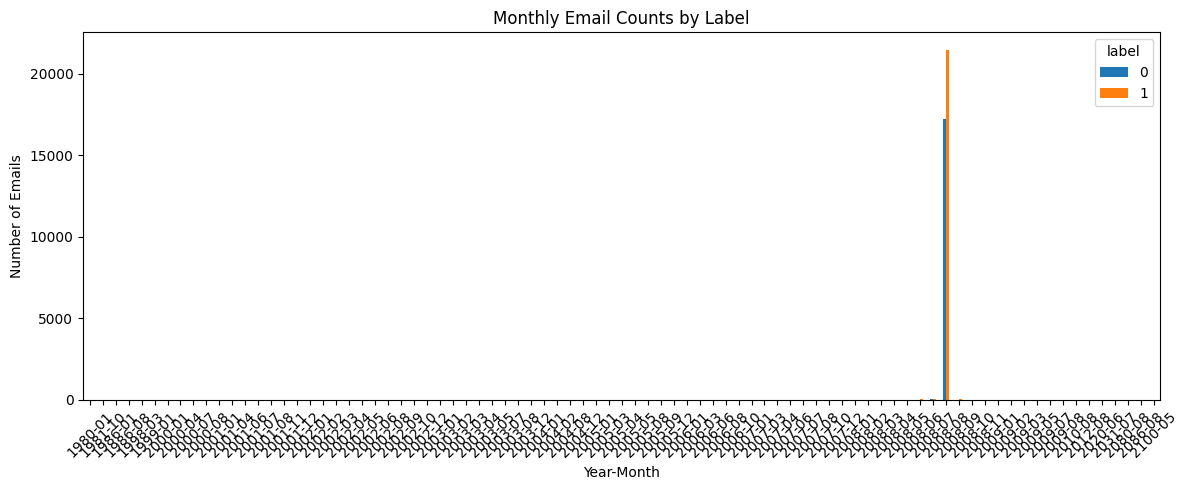

label,0,1
year_month,,
1980-01,0,1
1981-10,0,1
1986-01,0,1
1986-08,0,1
1998-03,0,2
...,...,...
2020-06,0,2
2031-07,0,1
2080-08,0,1


In [10]:
# Cell 9: Trend analysis using date (fixed)

# Parse date column to datetime with UTC awareness
df['date_parsed'] = pd.to_datetime(
    df['date'],
    errors='coerce',
    utc=True        # important to handle mixed time zones
)

# Check the dtype to confirm it's datetime-like
print("date_parsed dtype:", df['date_parsed'].dtype)

# Keep only valid dates
df_valid_date = df.dropna(subset=['date_parsed']).copy()

# Create month column (Year-Month)
df_valid_date['year_month'] = df_valid_date['date_parsed'].dt.to_period('M')

# Group by month and label (0 = ham, 1 = spam/phishing)
monthly_counts = df_valid_date.groupby(['year_month', 'label']).size().unstack(fill_value=0)

# Plot
monthly_counts.plot(kind='bar', figsize=(12, 5))
plt.title("Monthly Email Counts by Label")
plt.xlabel("Year-Month")
plt.ylabel("Number of Emails")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_counts


In [11]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    log_loss
)
from sklearn.ensemble import RandomForestClassifier

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    bootstrap=True,
    ccp_alpha=0.0,
    class_weight="balanced",
    criterion="gini",
    max_depth=None,
    max_features="sqrt",
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=0.01,
    min_samples_split=0.01,
    min_weight_fraction_leaf=0.0,
    n_estimators=100,
    n_jobs=-1,
    oob_score=True,
    random_state=42,
    verbose=0,
    warm_start=False
)

model = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_features=30000
    )),
    ('clf', rf_clf)
])

# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=30000, stop_words='english')),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=0.01,
                                        min_samples_split=0.01, n_jobs=-1,
                                        oob_score=True, random_state=42))])

In [13]:
X_train

,body
33091,do you still blanche at the thought of a futur...
31281,\nsize does matter - change your life today!\n...
34400,*** asf nagios ***\n\nnotification type: recov...
30771,\nwide range of tiffany and co. jewellry and m...
31563,"* aaron bennett :\n>\n> hi,\n>\n> i'm trying t..."
...,...
23285,safe money on gas http://www.bandquick.com/\n\n
27568,\nput on an average gain of 3.02 inches where ...
27066,\n\n\ncbsnews.com\n\n\n\n\n » unsubscribe / d...
11885,\ndear da1482440eb4bea7f128010f467699b9\n\nsum...


In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Use the full dataset with the Random Forest model
X_new = df["body"]
y_true = df["label"]
y_pred = model.predict(X_new)

print("Random Forest – accuracy on full dataset:",
      accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=["Legitimate", "Phishing"]))


Random Forest – accuracy on full dataset: 0.9568360023497561
              precision    recall  f1-score   support

  Legitimate       0.98      0.92      0.95     17311
    Phishing       0.94      0.98      0.96     21842

    accuracy                           0.96     39153
   macro avg       0.96      0.95      0.96     39153
weighted avg       0.96      0.96      0.96     39153



Random Forest – test set performance:
              precision    recall  f1-score   support

  Legitimate       0.98      0.93      0.95      3462
    Phishing       0.95      0.98      0.96      4369

    accuracy                           0.96      7831
   macro avg       0.96      0.96      0.96      7831
weighted avg       0.96      0.96      0.96      7831



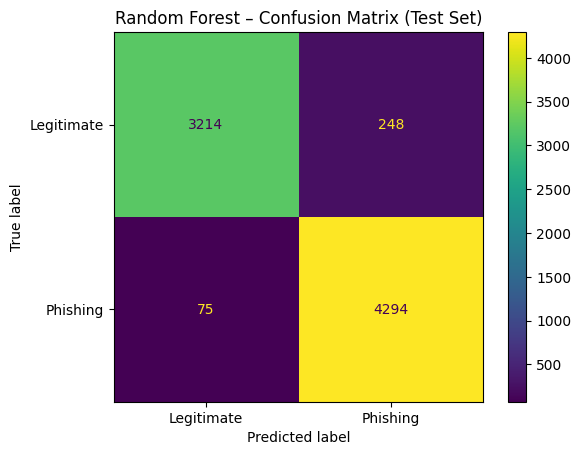

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

# Evaluate Random Forest on the test set (fair comparison with LR)
y_pred_test = model.predict(X_test)

print("Random Forest – test set performance:")
print(classification_report(y_test, y_pred_test,
                            target_names=["Legitimate", "Phishing"]))

# Plot confusion matrix for test set
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_test,
    display_labels=["Legitimate", "Phishing"]
)
plt.title("Random Forest – Confusion Matrix (Test Set)")
plt.show()


In [16]:
# 1. Build a fresh demo model (Logistic Regression with TF-IDF)
demo_model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=30000)),
    ('clf', LogisticRegression(max_iter=200, n_jobs=-1))
])

# 2. Train it on the training split (BODY only)
demo_model.fit(X_train, y_train)

# 3. Helper function to classify a new email BODY
def classify_email(body, model=demo_model):
    pred = model.predict([body])[0]
    return "Phishing" if pred == 1 else "Legitimate"

# Pick a real phishing email from the dataset (label = 1)
sample_phish = df[df["label"] == 1].sample(1, random_state=42)
demo_body = sample_phish["body"].iloc[0]

print("Email body:")
print(demo_body)
print("\nTrue label: Phishing (1)")
print("Model prediction:", classify_email(demo_body))


Email body:

dear bbaf0d8f5091008654f086221f7bb1f9

summer is a exact time to take a break at work and think about your health & personal life.

and we are glad to assist you with it.

 from now on till 30th of  october you can use our limited proposal.

visit our site for further details.

traditionstreet.com

6 aug 2008 05:05:01




True label: Phishing (1)
Model prediction: Phishing


In [17]:
# Demo on a real legitimate email from the dataset (label = 0)
sample_legit = df[df["label"] == 0].sample(1, random_state=7)

demo_body_legit = sample_legit["body"].iloc[0]

print("Email body:")
print(demo_body_legit)
print("\nTrue label: Legitimate (0)")
print("Model prediction:", classify_email(demo_body_legit))



Email body:
if an assertion in the response to an authnrequest does not contain a nameid in the subject, what is the meaning of the subjectconfirmation, in the context of sso profiles? the language in [samlcore] and in [samlprof], particularly as amended in the approved errata e47, speaks of the subject as if it's the nameid:

"if an assertion is issued for use by an entity other than the subject, then that entity should be
identified in the  element."

what would "other than the subject" mean in the above?

::ari

> -----original message-----
> from: scott cantor [mailto:bqbvdn.6@osu.edu]
> sent: sunday, march 02, 2008 2:49 pm
> to: 'tom scavo'
> cc: 'saml developers'
> subject: re: [saml-dev] nameid-less saml subject
> 
> 
> > interesting perspective.  the idp can't make this decision 
> on its own,
> > however, since the sp may require an identifier for account linking.
> 
> which could be (and has been in many cases) an attribute. as 
> i always try
> and explain, such decisions ha

In [18]:
# Cell: Train Logistic Regression and Random Forest (fresh, for comparison & dashboard)

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression pipeline
lr_model = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=30000)),
    ('clf', LogisticRegression(max_iter=200, n_jobs=-1))
])

# Random Forest pipeline
rf_model = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        max_features=30000
    )),
    ('clf', RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        min_samples_leaf=0.01,
        min_samples_split=0.01,
        n_jobs=-1,
        oob_score=True,
        random_state=42
    ))
])

# Train both models on the existing split
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

print("Logistic Regression and Random Forest trained (fresh models).")


Logistic Regression and Random Forest trained (fresh models).


=== Logistic Regression ===
Accuracy: 0.9948
              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99      3462
    Phishing       1.00      1.00      1.00      4369

    accuracy                           0.99      7831
   macro avg       0.99      0.99      0.99      7831
weighted avg       0.99      0.99      0.99      7831


=== Random Forest ===
Accuracy: 0.9588
              precision    recall  f1-score   support

  Legitimate       0.98      0.93      0.95      3462
    Phishing       0.95      0.98      0.96      4369

    accuracy                           0.96      7831
   macro avg       0.96      0.96      0.96      7831
weighted avg       0.96      0.96      0.96      7831




,Model,Accuracy,Legit_F1,Phishing_F1
0,Logistic Regression,0.994764,0.994079,0.995307
1,Random Forest,0.958754,0.952155,0.963753


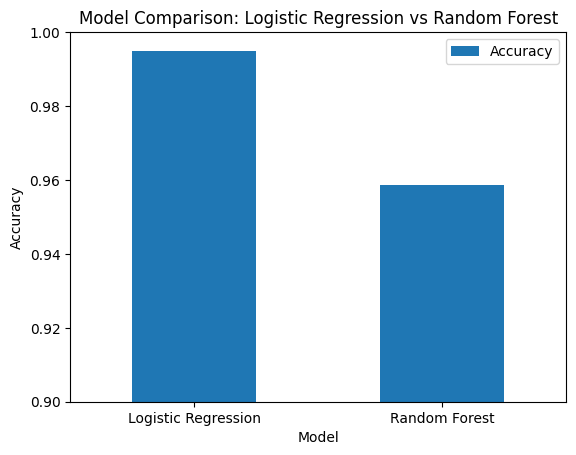

  LOGISTIC REGRESSION – PHISHING EMAIL DETECTION DASHBOARD
Overall accuracy        :  99.48%

Legitimate class (0):
  Precision             :  99.39%
  Recall                :  99.42%
  F1-score              :  99.41%

Phishing class (1):
  Precision             :  99.54%
  Recall                :  99.52%
  F1-score              :  99.53%



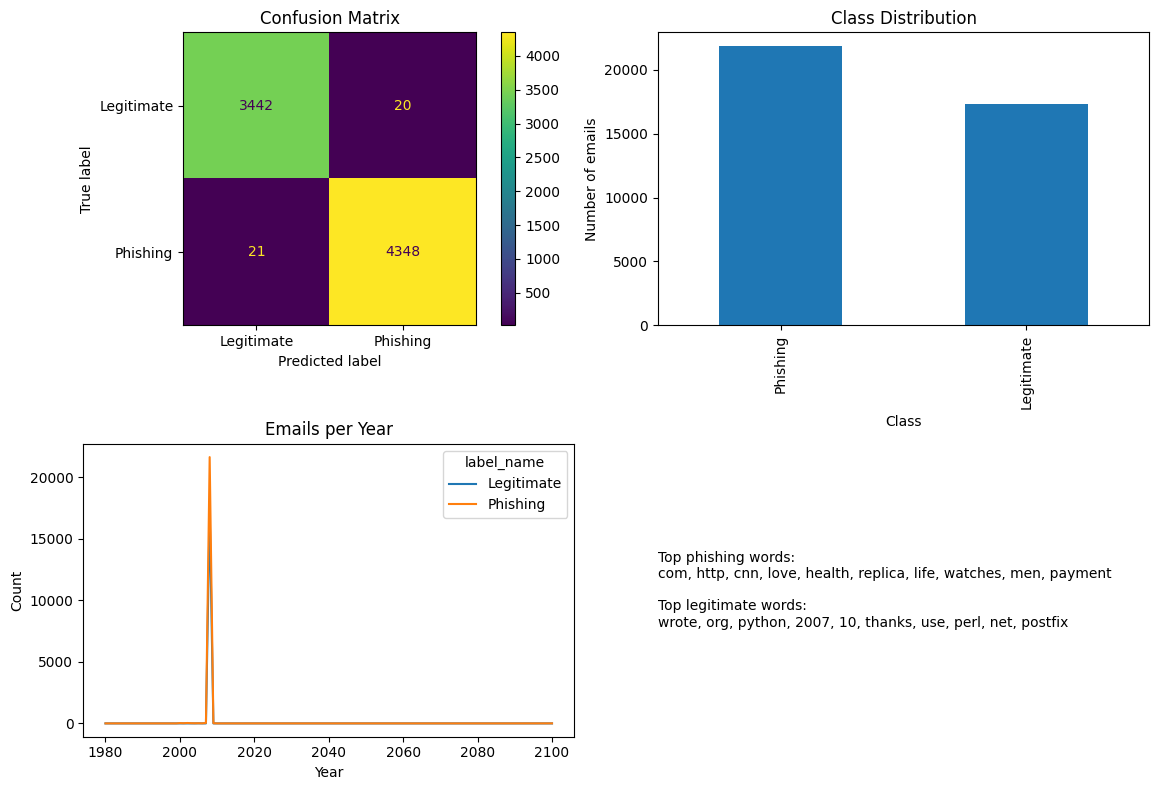

In [19]:
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1) Compare LR vs RF on the TEST set
models = {
    "Logistic Regression": lr_model,
    "Random Forest": rf_model
}

comparison_rows = []

for name, clf in models.items():
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report_dict = classification_report(
        y_test,
        y_pred,
        target_names=["Legitimate", "Phishing"],
        output_dict=True
    )

    comparison_rows.append({
        "Model": name,
        "Accuracy": acc,
        "Legit_F1": report_dict["Legitimate"]["f1-score"],
        "Phishing_F1": report_dict["Phishing"]["f1-score"]
    })

    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(
        y_test,
        y_pred,
        target_names=["Legitimate", "Phishing"]
    ))
    print()

comparison_df = pd.DataFrame(comparison_rows)
display(comparison_df)

# Simple accuracy bar chart (good for PPT screenshot)
comparison_df.set_index("Model")[["Accuracy"]].plot(kind="bar", ylim=(0.9, 1.0))
plt.ylabel("Accuracy")
plt.title("Model Comparison: Logistic Regression vs Random Forest")
plt.xticks(rotation=0)
plt.show()


# 2) Dashboard for the FINAL model (use Logistic Regression here)

def show_dashboard(model, model_name, X_test, y_test, df,
                   label_col="label",
                   date_col="date"):
    """
    Dashboard for a given model:
    - Summary metrics
    - Confusion matrix
    - Class distribution
    - Emails per year
    - Top words (for linear models like Logistic Regression)
    """

    label_map = {0: "Legitimate", 1: "Phishing"}

    df_local = df.copy()
    df_local["label_name"] = df_local[label_col].map(label_map)

    # === Summary metrics ===
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report_dict = classification_report(
        y_test,
        y_pred,
        target_names=["Legitimate", "Phishing"],
        output_dict=True
    )
    leg = report_dict["Legitimate"]
    phish = report_dict["Phishing"]

    print("=" * 60)
    print(f"  {model_name.upper()} – PHISHING EMAIL DETECTION DASHBOARD")
    print("=" * 60)
    print(f"Overall accuracy        : {acc*100:6.2f}%\n")
    print("Legitimate class (0):")
    print(f"  Precision             : {leg['precision']*100:6.2f}%")
    print(f"  Recall                : {leg['recall']*100:6.2f}%")
    print(f"  F1-score              : {leg['f1-score']*100:6.2f}%\n")
    print("Phishing class (1):")
    print(f"  Precision             : {phish['precision']*100:6.2f}%")
    print(f"  Recall                : {phish['recall']*100:6.2f}%")
    print(f"  F1-score              : {phish['f1-score']*100:6.2f}%")
    print("=" * 60)
    print()

    # === 2×2 plot grid ===
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Confusion matrix
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=["Legitimate", "Phishing"],
        ax=axes[0, 0]
    )
    axes[0, 0].set_title("Confusion Matrix")

    # Class distribution
    df_local["label_name"].value_counts().plot(kind="bar", ax=axes[0, 1])
    axes[0, 1].set_title("Class Distribution")
    axes[0, 1].set_ylabel("Number of emails")
    axes[0, 1].set_xlabel("Class")

    # Emails per year
    df_dates = df_local.copy()
    df_dates[date_col] = pd.to_datetime(df_dates[date_col], errors="coerce", utc=True)
    df_dates["year"] = df_dates[date_col].dt.year

    yearly = (
        df_dates.groupby(["year", "label_name"])
        .size()
        .unstack(fill_value=0)
        .sort_index()
    )

    yearly.plot(ax=axes[1, 0])
    axes[1, 0].set_title("Emails per Year")
    axes[1, 0].set_xlabel("Year")
    axes[1, 0].set_ylabel("Count")

    # Top words (only works for LR / linear models)
    axes[1, 1].axis("off")
    try:
        tfidf = model.named_steps["tfidf"]
        clf = model.named_steps["clf"]
        coefs = clf.coef_[0]
        feature_names = np.array(tfidf.get_feature_names_out())

        top_phish_idx = np.argsort(coefs)[-10:][::-1]
        top_legit_idx = np.argsort(coefs)[:10]

        top_phish_words = feature_names[top_phish_idx]
        top_legit_words = feature_names[top_legit_idx]

        text = (
            "Top phishing words:\n"
            + ", ".join(top_phish_words)
            + "\n\nTop legitimate words:\n"
            + ", ".join(top_legit_words)
        )
        axes[1, 1].text(0, 0.5, text, fontsize=10, va="center")
    except Exception:
        axes[1, 1].text(
            0, 0.5,
            "Top-word view available\nonly for linear models\n(e.g., Logistic Regression).",
            fontsize=10, va="center"
        )

    plt.tight_layout()
    plt.show()


# Call dashboard for your FINAL model (Logistic Regression)
show_dashboard(lr_model, "Logistic Regression", X_test, y_test, df,
               label_col="label", date_col="date")
